In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime as dt
import scipy.signal as ss

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
holidays_events = pd.read_csv("https://www.dropbox.com/s/bxyamlpevkiwwoq/holidays_events.csv?dl=1")
oil = pd.read_csv("https://www.dropbox.com/s/l6ln0ztl4m0pw3a/oil.csv?dl=1",parse_dates=['date'],index_col='date')
sample_submission = pd.read_csv("https://www.dropbox.com/s/68jjl61x6u3klos/sample_submission.csv?dl=1")
stores = pd.read_csv("https://www.dropbox.com/s/lcxn6r9bs2exguq/stores.csv?dl=1")
test = pd.read_csv("https://www.dropbox.com/s/cvdo1gn7r5lu2uz/test.csv?dl=1",index_col='id')
train = pd.read_csv("https://www.dropbox.com/s/s8p2b5awnuqfk0d/train.csv?dl=1",index_col='id')
transactions = pd.read_csv("https://www.dropbox.com/s/92fij9bcwt0e0cj/transactions.csv?dl=1")

In [4]:
train['date'] = pd.to_datetime(train['date'])

Dzielimy próbkę na treningową i testową.

In [5]:
train2 = train.loc[(train['date']<'2016-06-01')]

In [6]:
test2 = train.loc[(train['date']>='2016-06-01')]

In [7]:
oil_train2 = oil.loc[(oil.index<'2016-06-01')].fillna(method ="bfill")
oil_test2 = oil.loc[(oil.index>='2016-06-01')].fillna(method ="bfill")

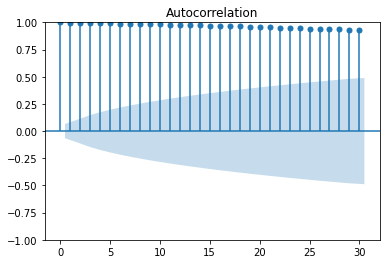

In [8]:
sm.graphics.tsa.plot_acf(oil_train2,lags=np.round(np.sqrt(len(oil_train2))))
plt.show()

C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


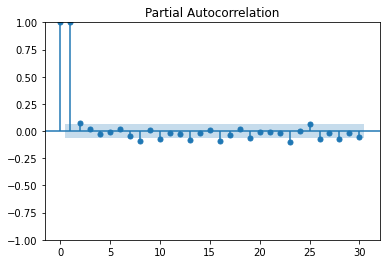

In [9]:
sm.graphics.tsa.plot_pacf(oil_train2,lags=np.round(np.sqrt(len(oil_train2))))
plt.show()

In [10]:
oil_diff = oil_train2.shift().diff().dropna()

In [11]:
sm.stats.acorr_ljungbox(oil_diff, lags=[np.round(np.sqrt(len(oil_diff)))], return_df=True)

,lb_stat,lb_pvalue
30,33.33492,0.308193


Zatem jest to biały szum.

In [13]:
mod_oil = sm.tsa.arima.ARIMA(oil_train2,order=(0,1,0)).fit()

C:\Users\ndzad\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
C:\Users\ndzad\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
C:\Users\ndzad\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'


In [14]:
train2_avg= train2.groupby('date')['sales'].mean().to_frame()

In [15]:
#Funkcja pomocniczna do rysowania wykresów
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100, axiscolor ='black'):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.gca().title.set_color(axiscolor)
    plt.gca().xaxis.label.set_color(axiscolor)
    plt.gca().yaxis.label.set_color(axiscolor)
    plt.tick_params(colors=axiscolor, which='both')
    plt.show()

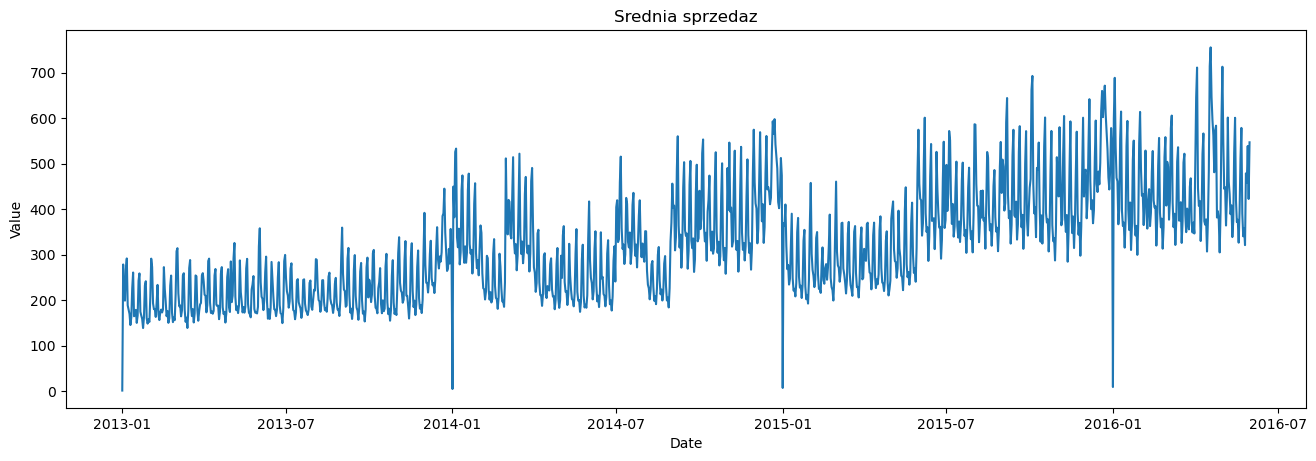

In [16]:
plot_df(train2_avg,x=train2_avg.index, y=train2_avg.sales, title='Srednia sprzedaz', axiscolor='black')

Wykres autokorelacji (ACF)

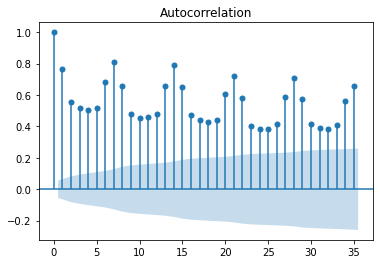

In [17]:
sm.graphics.tsa.plot_acf(train2_avg,lags=np.round(np.sqrt(len(train2_avg))))
plt.show()

Wykres cześciowych korelacji (PACF)

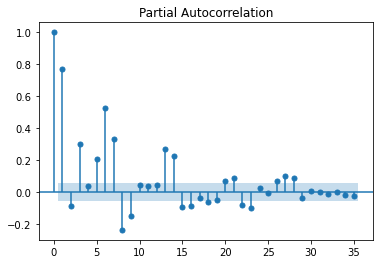

In [18]:
sm.graphics.tsa.plot_pacf(train2_avg,lags=np.round(np.sqrt(len(train2_avg))))
plt.show()

Różnicujemy szereg

In [19]:
train2_avg_diff = train2_avg.shift().diff().dropna()

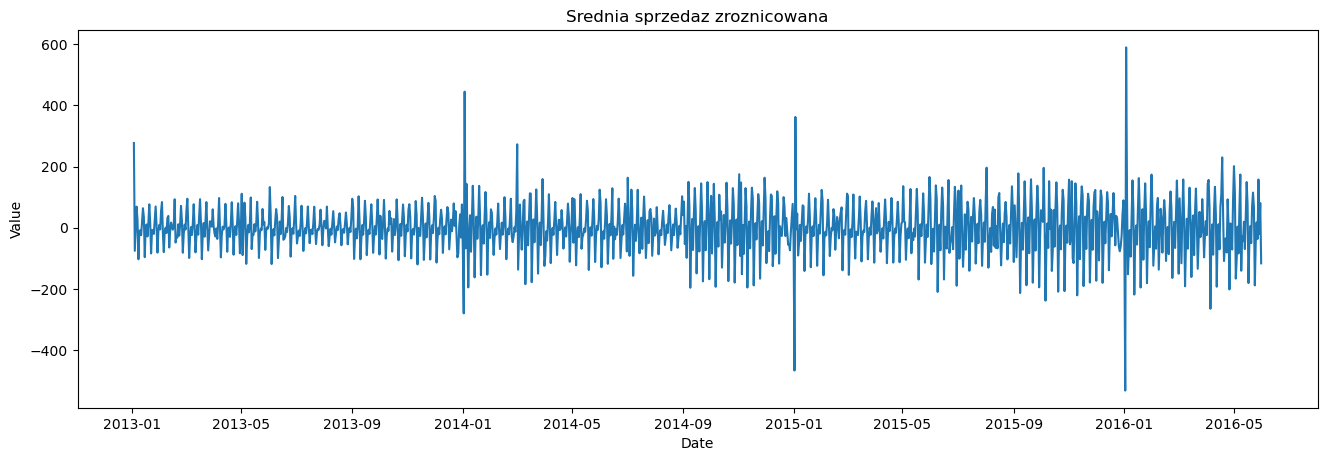

In [32]:
plot_df(train2_avg_diff,x=train2_avg_diff.index, y=train2_avg_diff.sales, title='Srednia sprzedaz zroznicowana', axiscolor='black')

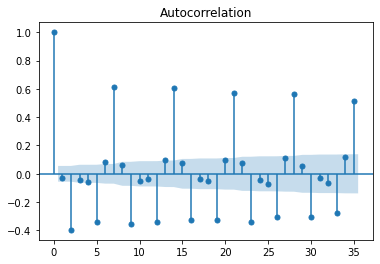

In [20]:
sm.graphics.tsa.plot_acf(train2_avg_diff,lags=np.round(np.sqrt(len(train2_avg_diff))))
plt.show()

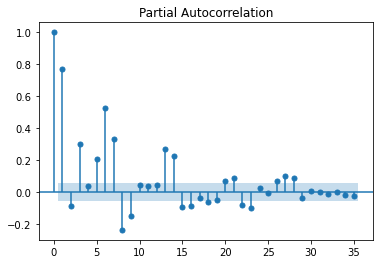

In [21]:
sm.graphics.tsa.plot_pacf(train2_avg,lags=np.round(np.sqrt(len(train2_avg))))
plt.show()

In [88]:
f, Pxx=ss.periodogram(train2_avg_diff,365)

In [90]:
Pxx

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [59]:
analysis = train2_avg_diff[['sales']].copy()

In [38]:
analysis.head(365)

,sales
date,
2013-01-01,1.409438
2013-01-02,278.390807
2013-01-03,202.840197
2013-01-04,198.911154
2013-01-05,267.873244
...,...
2013-12-28,312.543382
2013-12-29,280.426209
2013-12-30,356.416799


In [60]:
decompose_result_add = seasonal_decompose(analysis,model="additive",freq=365)

C:\Users\ndzad\AppData\Local\Temp/ipykernel_14372/3939235887.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decompose_result_add = seasonal_decompose(analysis,model="additive",freq=365)


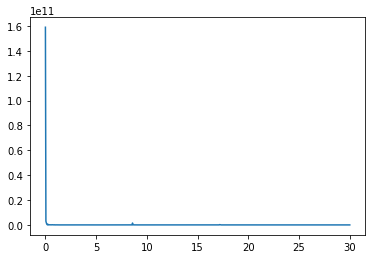

In [98]:
fourier_transform = np.fft.rfft(train2_avg['sales'])

abs_fourier_transform = np.abs(fourier_transform)

power_spectrum = np.square(abs_fourier_transform)

frequency = np.linspace(0, 30, len(power_spectrum))

plt.plot(frequency, power_spectrum)

In [97]:
power_spectrum

array([1.59001702e+11, 3.02906674e+09, 1.49353573e+09, 5.18029454e+08,
       1.00869311e+08, 5.89838015e+08, 2.21398735e+07, 8.11218716e+07,
       1.13933789e+08, 8.74962096e+07, 9.66002254e+07, 3.37104385e+07,
       5.83902176e+07, 1.08142605e+08, 1.22123753e+08, 7.54546592e+07,
       1.30685279e+07, 6.27719461e+07, 2.17099013e+07, 1.05621241e+08,
       3.46946163e+06, 4.15632494e+07, 3.87117969e+07, 2.70529026e+07,
       2.15227676e+07, 3.08356684e+06, 1.79380148e+07, 9.30038951e+06,
       6.56590360e+06, 2.95658957e+06, 1.68079513e+06, 3.61347386e+07,
       5.64471074e+06, 7.34638383e+06, 2.42738931e+07, 2.99809416e+04,
       3.74773287e+06, 6.93868227e+06, 3.27015925e+07, 7.65861101e+06,
       1.49680456e+06, 7.76926064e+07, 7.72051266e+06, 5.29216095e+06,
       6.80140231e+06, 5.51919223e+05, 6.78136834e+06, 2.68732768e+05,
       7.11964080e+06, 6.42707396e+06, 6.56755773e+04, 1.31116314e+07,
       2.90434330e+06, 1.36922912e+06, 2.60621140e+05, 1.27779557e+07,
      